## Notebook for changing the humidity forcing

relative humidity (which we want to stay constant) is 
$$ \psi = \frac{e}{e_s} \times 100 $$
where $e$ is the partial water vapour pressure and $e_s$ the saturation vapor pressure $e_s$ determined by the temperature.
The specific humidity (model parameter) is 
$$ q = \frac{m_w}{m} = \frac{\frac{M_w}{M_d}e}{p-(1-\frac{M_w}{M_d})e} $$
where $M_d=28.9634$gmol$^{-1}$ is the molar mass of dry air, $p$ the atmospheric pressure. If we assume $\frac{M_w}{M_d} \approx 0.622$ we can simplify the formula, $$q \approx \frac{0.622e}{p-0.378e}$$
and rearranging for $e$:
$$e = \frac{qp}{0.622+0.378q}$$

Finally the saturation water vapor pressure $e_s$ can be determined from the temperature via the Clausius-Clapeyron relation:
$$e_s(T)=e_s(T_0) \times \exp{ \frac{L}{R_w} \left( \frac{1}{T_0}-\frac{1}{T} \right) } $$

where $e_s(T_0) = 6.11$hPa, $T_0 = 273.15K$, $L = 2.5 \times 10^6$Jkg$^{-1}$ is the latent heat, $R_w = 462.52$J/kgK is the specific gas constant for water vapour and $M_w = 18.01528$gmol$^{-1}$

Source: https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
from xhistogram.xarray import histogram

In [2]:
db = '/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_humidity.db'
session = cc.database.create_session(db)

Loading the .nc files into a database so that I can use to cosima cookbook

In [3]:
dir_list=['/scratch/e14/cy8964/access-om2/input/RYF.q_10.1990_1991.nc',
          '/scratch/e14/cy8964/access-om2/input/RYF.slp.1990_1991.nc',
          '/scratch/e14/cy8964/access-om2/input/RYF.t_10.1990_1991.nc',
          '/scratch/e14/cy8964/access-om2/input/RYF.t_10.1990_1991_rcpwarm.nc',
          '/scratch/e14/cy8964/access-om2/input/RYF.q_10.1990_1991_rcpwarmhumid_v2.nc',
          '/scratch/e14/cy8964/access-om2/input/RYF.t_10.1990_1991_rcpwarm2x.nc',
          '/scratch/e14/cy8964/access-om2/input/RYF.t_10.1990_1991_rcpcool.nc',
          '/scratch/e14/cy8964/access-om2/input/RYF.t_10.1990_1991_rcpcool2x.nc',
          '/scratch/e14/cy8964/access-om2/input/RYF.q_10.1990_1991_rcpwarmhumid2x.nc',
          '/scratch/e14/cy8964/access-om2/input/RYF.q_10.1990_1991_rcpcoolhumid.nc',
          '/scratch/e14/cy8964/access-om2/input/RYF.q_10.1990_1991_rcpcoolhumid2x.nc'
          ]

cc.database.build_index(dir_list, session, update=True)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Indexing experiment: RYF.q_10.1990_1991.nc
Indexing experiment: RYF.slp.1990_1991.nc
Indexing experiment: RYF.t_10.1990_1991.nc
Indexing experiment: RYF.t_10.1990_1991_rcpwarm.nc
Indexing experiment: RYF.q_10.1990_1991_rcpwarmhumid_v2.nc
Indexing experiment: RYF.t_10.1990_1991_rcpwarm2x.nc
Indexing experiment: RYF.t_10.1990_1991_rcpcool.nc
Indexing experiment: RYF.t_10.1990_1991_rcpcool2x.nc



0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Indexing experiment: RYF.q_10.1990_1991_rcpwarmhumid2x.nc
Indexing experiment: RYF.q_10.1990_1991_rcpcoolhumid.nc
Indexing experiment: RYF.q_10.1990_1991_rcpcoolhumid2x.nc


0

In [4]:
session = cc.database.create_session('/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_humidity.db')

In [5]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,RYF.q_10.1990_1991.nc,1
1,RYF.slp.1990_1991.nc,1
2,RYF.t_10.1990_1991.nc,1
3,RYF.t_10.1990_1991_rcpwarm.nc,1
4,RYF.q_10.1990_1991_rcpwarmhumid.nc,1
5,RYF.q_10.1990_1991_rcpwarmhumid_v2.nc,1
6,RYF.t_10.1990_1991_rcpwarm2x.nc,1
7,RYF.t_10.1990_1991_rcpcool.nc,1
8,RYF.t_10.1990_1991_rcpcool2x.nc,1
9,RYF.q_10.1990_1991_rcpwarmhumid2x.nc,1


In [7]:
temp_warm = cc.querying.getvar('RYF.t_10.1990_1991_rcpwarm2x.nc', 'tas_10m', session)
temp_control = cc.querying.getvar('RYF.t_10.1990_1991.nc', 'tas_10m', session)
p_control = cc.querying.getvar('RYF.slp.1990_1991.nc', 'psl', session,chunks={'time':None})
q_control = cc.querying.getvar('RYF.q_10.1990_1991.nc', 'huss_10m', session)
q_warmhumidcheck = cc.querying.getvar('RYF.q_10.1990_1991_rcpwarmhumid2x.nc', 'huss_10m', session)

### Check that the temperature and anomalies look right

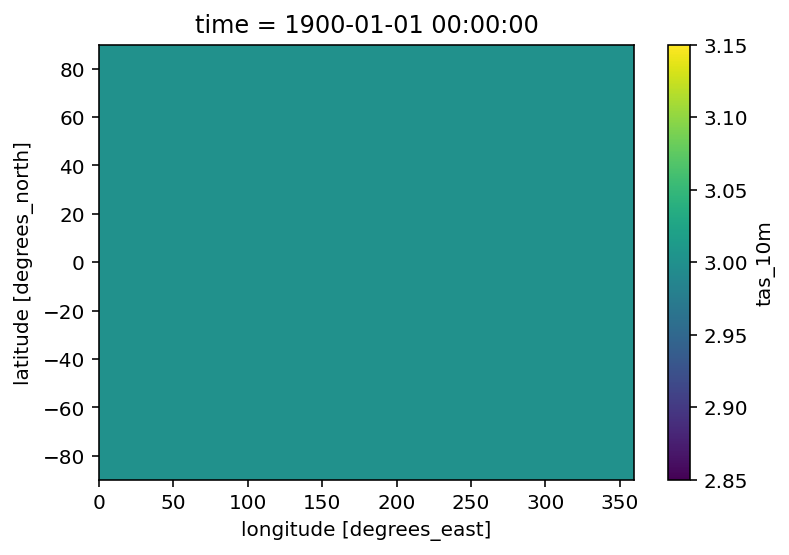

In [8]:
(temp_warm-temp_control).isel(time = 0).plot() #indeed the temperature forcing has been changed by 1/5 degrees

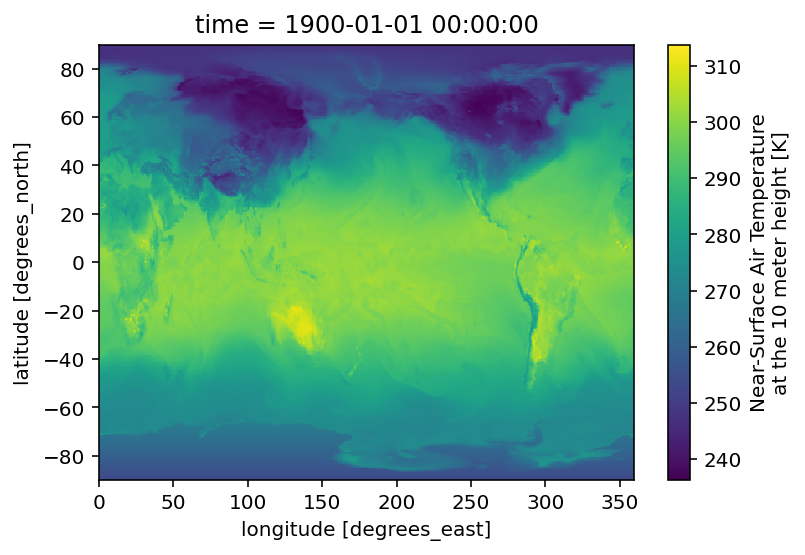

In [9]:
temp_control.isel(time = 0).plot()

Recall

$$e = \frac{qp}{0.622+0.378q}$$
$$e_s(T)=e_s(T_0) \times \exp{ \frac{L}{R_w} \left( \frac{1}{T_0}-\frac{1}{T} \right) } $$

where $e_s(T_0) = 6.11$hPa, $T_0 = 273.15K$, $L = 2.5 \times 10^6$Jkg$^{-1}$ is the latent heat, $R_w = 462.52$J/kgK is the specific gas constant for water vapour and $M_w = 18.01528$gmol$^{-1}$

if we want e/e_s to be a constant we want
 $$\frac{\frac{qp}{0.622+0.378q}}{\exp{ \frac{L}{R_w} \left( \frac{1}{T_0}-\frac{1}{T} \right) }} = \frac{\frac{q_{new}p}{0.622+0.378q_{new}}}{\exp{ \frac{L}{R_w} \left( \frac{1}{T_0}-\frac{1}{T_{new}} \right) }} $$  
 
 solve for q_new:

$$\frac{\frac{qp}{0.622+0.378q}}{\exp{ \frac{L}{R_w} \left( \frac{1}{T_0}-\frac{1}{T} \right) }} \exp{ \frac{L}{R_w} \left( \frac{1}{T_0}-\frac{1}{T_{new}} \right) }= \frac{q_{new}p}{0.622+0.378q_{new}} $$  
$$\frac{\frac{qp}{0.622+0.378q}}{\exp{ \frac{L}{R_w} \left( \frac{1}{T_{new}}-\frac{1}{T} \right) }} \times (0.622+0.378q_{new}) = q_{new}p $$  

$$\frac{\frac{qp}{0.622+0.378q}}{\exp{ \frac{L}{R_w} \left( \frac{1}{T_{new}}-\frac{1}{T} \right) }} \times (0.622) = - 0.378q_{new} \times \frac{\frac{qp}{0.622+0.378q}}{\exp{ \frac{L}{R_w} \left( \frac{1}{T_{new}}-\frac{1}{T} \right) }}+ q_{new}p $$  

$$q_{new} = \frac{\frac{\frac{qp}{0.622+0.378q}}{\exp{ \frac{L}{R_w} \left( \frac{1}{T_{new}}-\frac{1}{T} \right) }} \times (0.622)}{\left( p- 0.378\frac{\frac{qp}{0.622+0.378q}}{\exp{ \frac{L}{R_w} \left( \frac{1}{T_{new}}-\frac{1}{T} \right) }} \right) } $$  

$$q_{new} = \frac{\frac{qp}{0.622+0.378q} \times (0.622)}{\left( p\exp{ \frac{L}{R_w} \left( \frac{1}{T_{new}}-\frac{1}{T} \right) }- 0.378\frac{qp}{0.622+0.378q} \right) } $$  

$$q_{new} = \frac{e \times (0.622)}{\left( p\exp{ \frac{L}{R_w} \left( \frac{1}{T_{new}}-\frac{1}{T} \right) }- 0.378e \right) } $$  

### Check units for pressure!!! They are in Pa so should be ok but be careful.

Using the above equations to find the new q_new

In [12]:
e_control = q_control*p_control/(0.622+0.378*q_control)
e_s_0 = 6.11*100 #Pa
T_0 = 273.15 #K

In [13]:
L = 2.5*10**6 #J/kg
R_w = 462.52#J/kgK
q_new = e_control*0.622/(p_control*np.exp(L/R_w *(1/temp_warm - 1/temp_control))-0.378*e_control)

Checking that we've done the right thing

In [14]:
e_new = q_new*p_control/(0.622+0.378*q_new)

In [15]:
e_s_control = e_s_0 * np.exp(L/R_w*(1/T_0-1/temp_control))

In [16]:
e_s_new = e_s_0 * np.exp(L/R_w*(1/T_0-1/temp_warm))

In [17]:
rel_humid_control = e_control/e_s_control

In [18]:
rel_humid_new = e_new/e_s_new

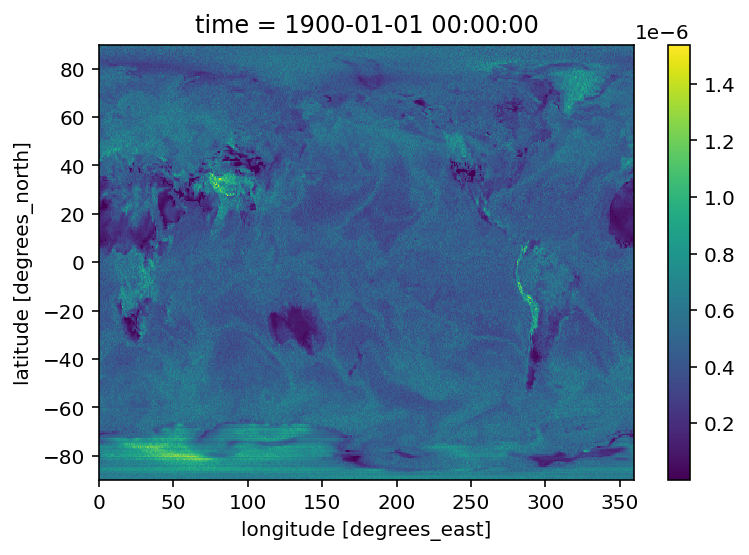

In [19]:
(rel_humid_control-rel_humid_new).isel(time = 0).plot()

Relative error:

In [ ]:
((rel_humid_control-rel_humid_new)/rel_humid_control).isel(time=2919).plot()

error if we don't change specific humidity:

In [22]:
rel_humid_old = e_control/e_s_new #change T but not q

indeed the humidity decreases (control > old) when the temp increased but specific humidity kept the same

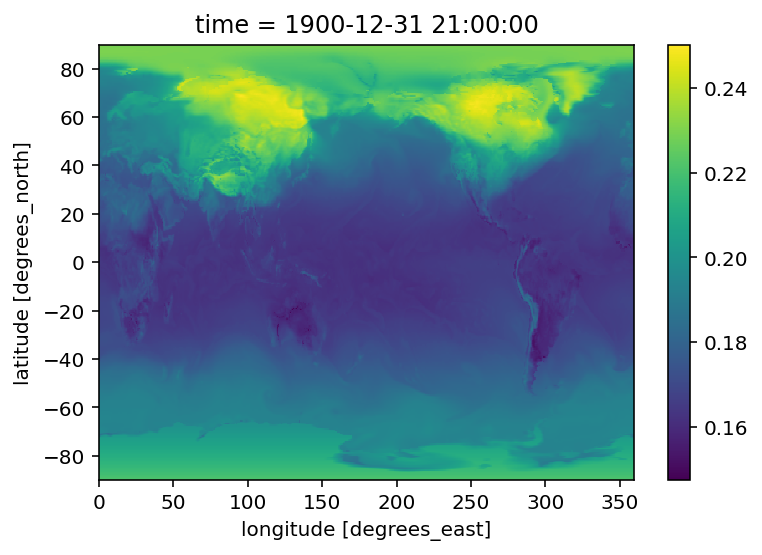

In [26]:
((rel_humid_control-rel_humid_old)/rel_humid_control).isel(time=2919).plot()

the error is much larger, which makes sense. thus i am happy with my 10^-6 error in keeping relative humidity constant.

now need to write q_new to a .nc file

EXTRA: Relative error of out new forcing after it has been compiled to check: (define q_warmhumidcheck at the top)

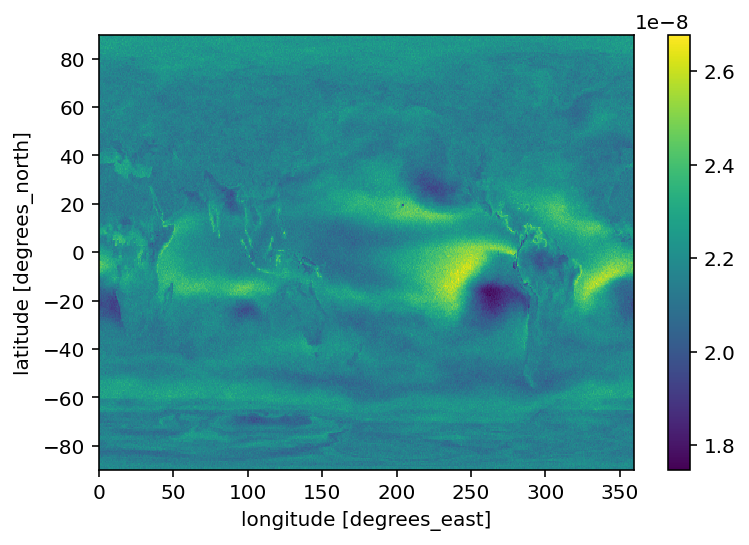

In [145]:
(abs(q_new-q_warmhumidcheck)/q_new).mean('time').plot()

In [46]:
import netCDF4 as nc
import numpy as np
import cftime

fn = '/scratch/e14/cy8964/access-om2/input/RYF.q_10.1990_1991_test5.nc '
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', 2920)
latitude = ds.createDimension('latitude', 320)
longitude = ds.createDimension('longitude', 640)

times = ds.createVariable('time', 'S1', ('time',))
lats = ds.createVariable('latitude', 'f8', ('latitude',))
lons = ds.createVariable('longitude', 'f8', ('longitude',))
value = ds.createVariable('huss_10m', 'f4', ('time', 'latitude', 'longitude',))
value.units = 'kg/kg'
value.long_name = 'Near-Surface Specific Humidity at the 10 meter height'
value.short_name = 'specific_humidity'

lats[:] = q_control.latitude
lons[:] = q_control.longitude
times[:]= q_control.time

value = q_new.values

ds.close()

# netcdf updating - remember to use ncfile.close() after use or you will ruin the file.

In the Dataset command mode use r+ for reading and then editing. r for reading. Do not use w, it wipes everything

In [25]:
from netCDF4 import Dataset    # Note: python is case-sensitive!
import numpy as np

In [78]:
ncfile = Dataset('/scratch/e14/cy8964/access-om2/input/RYF.q_10.1990_1991_rcpcoolhumid2x.nc',mode='r') #use r+ to edit

In [79]:
print(ncfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Adjusted 10 m specific humidity of JRA55-do
    institution: JMA Meteorological Research Institute
    comment: None
    version: v1.3
    fill_value: Fill value is -9.99e33
    dimensions(sizes): latitude(320), longitude(640), time(2920)
    variables(dimensions): float64 latitude(latitude), float64 longitude(longitude), float64 time(time), float32 huss_10m(time,latitude,longitude)
    groups: 


In [80]:
ncfile.variables["huss_10m"]

<class 'netCDF4._netCDF4.Variable'>
float32 huss_10m(time, latitude, longitude)
    _FillValue: -9.99e+33
    units: kg/kg
    long_name: Near-Surface Specific Humidity at the 10 meter height
    standard_name: specific_humidity
unlimited dimensions: time
current shape = (2920, 320, 640)
filling on

Check that it works for a random coordinate

In [82]:
q_new.isel(time=2919,latitude=180,longitude=48).values

array(0.00419821)

In [85]:
ncfile.variables["huss_10m"][2919,180,48]

masked_array(data=0.00419821,
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [84]:
for t in np.arange(0,2920):
    ncfile.variables["huss_10m"][t,:,:] = q_new.isel(time = t).values
    print(t)







0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [86]:
ncfile.close()